# BERT

**BERT** имеет преимущество перед такими моделями, как Word2Vec, потому что в Word2Vec каждое слово имеет фиксированное представление независимо от контекста, в котором слово употребляется,  **BERT** создаёт представления слов, которое учитывает контекст, в котором слово употребляется. Например,

1. После сражения рыцарь направился в замок.
2. Замок настолько проржавел, что дверь невозможно было открыть.

**BERT** имеет два ограничения:

* Все предложения должны быть дополнены или усечены до единой фиксированной длины.
* Максимальная длина предложения - 512 токенов.

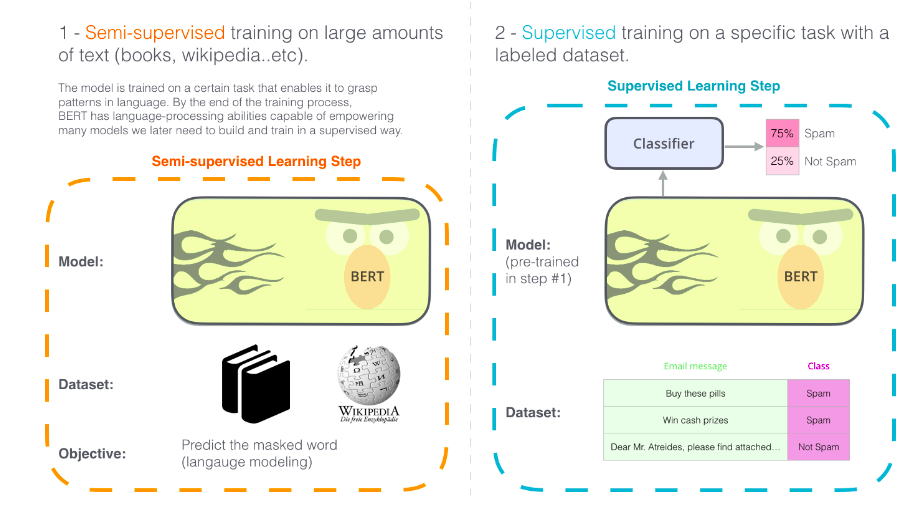

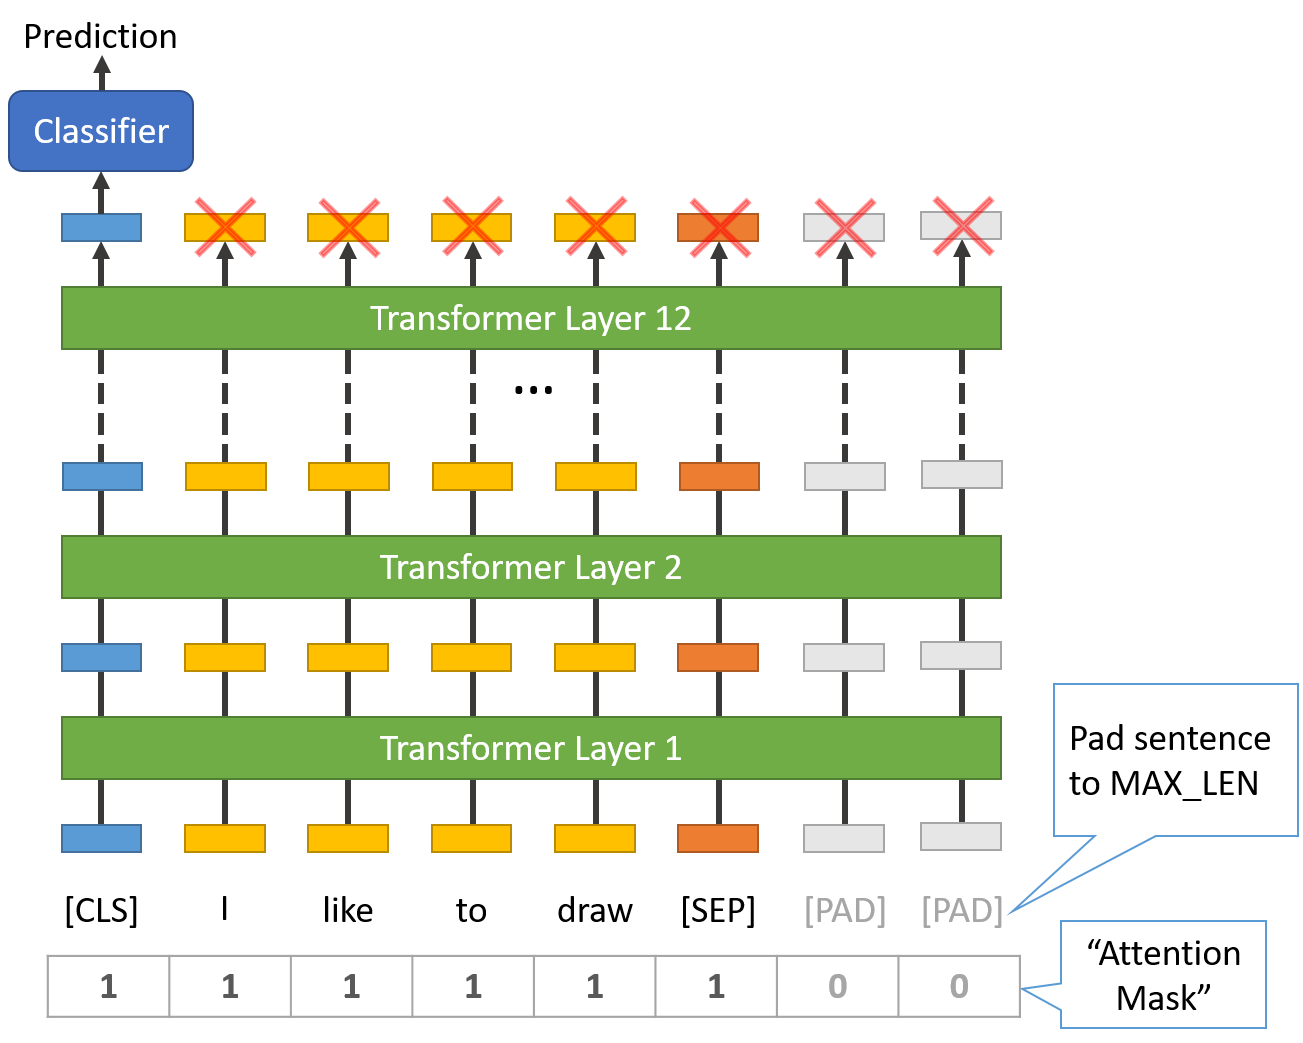

«Attention mask» - это просто массив из единиц и нулей, указывающих, какие токены заполняются, а какие нет. Эта маска сообщает механизму «Self-Attention» в BERT не включать эти токены [PAD] в свою интерпретацию предложения.

Однако максимальная длина влияет на скорость обучения и оценки. Например, с Tesla K80:

MAX_LEN = 128 --> Training epochs take ~5:28 each

MAX_LEN = 64 --> Training epochs take ~2:57 each

In [2]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 49.9 MB/s 
     |████████████████████████████████| 636 kB 82.9 MB/s 
     |████████████████████████████████| 895 kB 57.4 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**transformers** включает в себя различные классы задач для BERT (token classification, text classification, …). Здесь будем использовать basic BertModel, которая не имеет конкретной задачи вывода, поэтому хороша подходит для построения embeddings.

In [3]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
% matplotlib inline

# Загружаем предобученную модель 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## **Input Formatting**

Поскольку BERT - это предварительно обученная модель, которая ожидает входные данные в определенном формате, нам потребуются:

* **Special token [SEP]** - указывает на конец предложения или на разделение между двумя предложениями 

* **Special token [CLS]** - ставится в начале текста и используется для задач классификации 

* Токены, соответствующие фиксированному словарю, используемому в BERT

* **Token IDs**  для токенов из BERT’s tokenizer

* **Mask IDs** - указывает на то, какие элементы в последовательности являются токенами, а какие необходимо пропустить для их предсказания 

* **Segment IDs** - используются для различения разных предложений

* **Positional Embeddings** - используются для отображения позиции токена в последовательности

**transformers** учитывает все вышеперечисленные требования (с помощью tokenizer.encode_plus).

### **Special Tokens**

**BERT** может принимать в качестве входных данных одно или два предложения и использовать специальный токен **[SEP]** для их разделения. Токен **[CLS]**  (classification) ставится в начале текста и применяется для задач классификации.

Однако всегда требуются оба токена, даже если у нас есть только одно предложение и даже если мы не используем BERT для классификации. 

**2 Sentence Input:**

[CLS] The man went to the store. [SEP] He bought a gallon of milk.

**1 Sentence Input:**

[CLS] The man went to the store. [SEP]

### **Tokenization**

**BERT** предоставляет собственный токенизатор, который мы импортировали выше. 

In [4]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Токенизация предложения с помощью BERT tokenizer
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


**embeddings = ['em', '##bed', '##ding', '##s']**

Исходное слово было разделено на более мелкие подслова и символы. Два знака решетки, предшествующие некоторым из этих подслов, - всего лишь способ нашего токенизатора обозначить, что это подслово или символ является частью большего слова и ему предшествует другое подслово. Так, например, токен **##bed** отделен от токена **bed**; первый используется всякий раз, когда подслово  **bed** встречается в более крупном слове, а второй используется явно, когда возникает самостоятельный токен «вещь, на которой вы спите».

BERT tokenizer был создан на основе модели WordPiece.

Токенизатор сначала проверяет, есть ли слово целиком в словаре. В противном случае он пытается разбить слово на как можно больше подслов, содержащихся в словаре, и в крайнем случае разложит слово на отдельные символы. То есть слово всегдв можно представить как набор его отдельных символов. 

несколько примеров токенов, содержащихся словар:

In [ ]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

После разбиения текста на токены необходимо преобразовать предложение из списка строк в список словарных индексов.


In [ ]:
# Зададим текст с различным значением для слова 'bank'
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Добавим специальные токены
marked_text = "[CLS] " + text + " [SEP]"

# Разделим текст на токены
tokenized_text = tokenizer.tokenize(marked_text)

# Сопоставим токены их индексам в словаре
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Вывведем токены с соответсвующими им индексами в словаре
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


### **Inspect BERT Vocabulary**

Первые 999 токенов (с индексом 1) зарезервированы, и большинство из них имеют форму [unused957].
* 1 - [PAD]
* 101 - [UNK]
* 102 - [CLS]
* 103 - [SEP]
* 104 - [MASK]

Строки 1000–1996 - отдельные символы, которые не отсортированы по частоте (например, все буквы алфавита расположены последовательно).

Первый токен-слово - **the** в позиции 1997. Далее токены отсортированы по частоте.

Первые ~ 18 токенов - целые слова, на месте 2016 идёт токен **##s** (самое распространенное подслово).
Последний токен словаря на месте 29612 - это слово **necessitated**.

*Интересные включения*:
* starbucks
* triassic
* abolitionist
* 1679

Для каждого отдельного символа существует также версия '##'. Всего 997 односимвольных токенов.

In [5]:
one_chars = []
one_chars_hashes = []

# Для каждого докенв из словаря
for token in tokenizer.vocab.keys():
    
    # Извлекаем односимвольные токены
    if len(token) == 1:
        one_chars.append(token)
    
    # Извлекаем односимвольные токены с ## (односимвольное подслово)
    elif len(token) == 3 and token[0:2] == '##':
        one_chars_hashes.append(token)

In [7]:
print('Количество односимвольных токенов:', len(one_chars), '\n')

# Вывести все одиночные символы (по 40 в каждой строке)

# Для каждого batch из 40 токенов
for i in range(0, len(one_chars), 40):
    end = min(i + 40, len(one_chars) + 1)
    print(' '.join(one_chars[i:end]))

Количество односимвольных токенов: 997 

! " # $ % & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; < = > ? @ [ \ ] ^ _ ` a b
c d e f g h i j k l m n o p q r s t u v w x y z { | } ~ ¡ ¢ £ ¤ ¥ ¦ § ¨ © ª « ¬
® ° ± ² ³ ´ µ ¶ · ¹ º » ¼ ½ ¾ ¿ × ß æ ð ÷ ø þ đ ħ ı ł ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɛ ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ː ˡ ˢ ˣ ˤ α β γ δ
ε ζ η θ ι κ λ μ ν ξ ο π ρ ς σ τ υ φ χ ψ ω а б в г д е ж з и к л м н о п р с т у
ф х ц ч ш щ ъ ы ь э ю я ђ є і ј љ њ ћ ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ
ք ־ א ב ג ד ה ו ז ח ט י ך כ ל ם מ ן נ ס ע ף פ ץ צ ק ר ש ת ، ء ا ب ة ت ث ج ح خ د
ذ ر ز س ش ص ض ط ظ ع غ ـ ف ق ك ل م ن ه و ى ي ٹ پ چ ک گ ں ھ ہ ی ے अ आ उ ए क ख ग च
ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ ই উ এ ও ক খ গ চ ছ জ
ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப ம ய ர ல ள வ ா ி ு ே
ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད ན པ བ མ འ ར ལ ས မ ა
ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ ᄋ ᄌ ᄎ ᄏ ᄐ ᄑ ᄒ ᅡ ᅢ ᅥ ᅦ ᅧ ᅩ ᅪ ᅭ ᅮ

In [9]:
print('Количество односимвольных подслов с ##:', len(one_chars_hashes), '\n')

# Для наглядности удалим ## перед токенами
tokens = [token.replace('##', '') for token in one_chars_hashes]
for i in range(0, len(tokens), 40):
    end = min(i + 40, len(tokens) + 1)
    print(' '.join(tokens[i:end]))

Количество односимвольных подслов с ##: 997 

s a e i n o d r y t l m u h k c g p 2 z 1 b 3 f 4 6 7 x v 8 5 9 0 w j q ° ₂ а и
² ₃ ı ₁ ⁺ ½ о ه ي α е د ن ν ø р ₄ ₀ ر я ³ ι ł н ᵢ ₙ ß ة ς م − т ː ل ь к ♭ η ی в
ا × ¹ ы ה ɛ л ! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ ¡
¢ £ ¤ ¥ ¦ § ¨ © ª « ¬ ® ± ´ µ ¶ · º » ¼ ¾ ¿ æ ð ÷ þ đ ħ ŋ œ ƒ ɐ ɑ ɒ ɔ ɕ ə ɡ ɣ ɨ
ɪ ɫ ɬ ɯ ɲ ɴ ɹ ɾ ʀ ʁ ʂ ʃ ʉ ʊ ʋ ʌ ʎ ʐ ʑ ʒ ʔ ʰ ʲ ʳ ʷ ʸ ʻ ʼ ʾ ʿ ˈ ˡ ˢ ˣ ˤ β γ δ ε ζ
θ κ λ μ ξ ο π ρ σ τ υ φ χ ψ ω б г д ж з м п с у ф х ц ч ш щ ъ э ю ђ є і ј љ њ ћ
ӏ ա բ գ դ ե թ ի լ կ հ մ յ ն ո պ ս վ տ ր ւ ք ־ א ב ג ד ו ז ח ט י ך כ ל ם מ ן נ ס
ע ף פ ץ צ ק ר ש ת ، ء ب ت ث ج ح خ ذ ز س ش ص ض ط ظ ع غ ـ ف ق ك و ى ٹ پ چ ک گ ں ھ
ہ ے अ आ उ ए क ख ग च ज ट ड ण त थ द ध न प ब भ म य र ल व श ष स ह ा ि ी ो । ॥ ং অ আ
ই উ এ ও ক খ গ চ ছ জ ট ড ণ ত থ দ ধ ন প ব ভ ম য র ল শ ষ স হ া ি ী ে க ச ட த ந ன ப
ம ய ர ல ள வ ா ி ு ே ை ನ ರ ಾ ක ය ර ල ව ා ก ง ต ท น พ ม ย ร ล ว ส อ า เ ་ ། ག ང ད
ན པ བ མ འ ར ལ ས မ ა ბ გ დ ე ვ თ ი კ ლ მ ნ ო რ ს ტ უ ᄀ ᄂ ᄃ ᄅ ᄆ ᄇ ᄉ ᄊ ᄋ ᄌ ᄎ 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Максимальная длина токена: 18


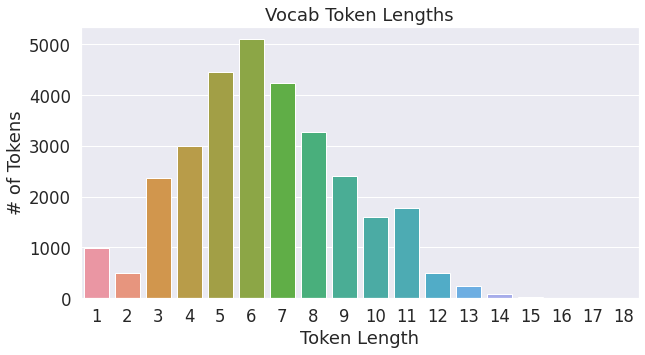

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)
# Длина каждого токена в словаре
token_lengths = [len(token) for token in tokenizer.vocab.keys()]
sns.countplot(token_lengths)
plt.title('Vocab Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('# of Tokens')

print('Максимальная длина токена:', max(token_lengths))

In [11]:
num_subwords = 0

subword_lengths = []

# Для каждого токена из словаря
for token in tokenizer.vocab.keys():   
    # Если это подслово
    if len(token) >= 2 and token[0:2] == '##':        
        # Подсчитать все подслова
        num_subwords += 1
        # Длина подслова без учёта ##
        length = len(token) - 2       
        subword_lengths.append(length)

In [13]:
vocab_size = len(tokenizer.vocab.keys())

print('Количество подслов: {:,} из {:,}'.format(num_subwords, vocab_size))

# Подсчёт отношения подслов ко всем токенам
prcnt = float(num_subwords) / vocab_size * 100.0

print('%.1f%%' % prcnt)

Количество подслов: 5,828 из 30,522
19.1%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of ## Subwords')

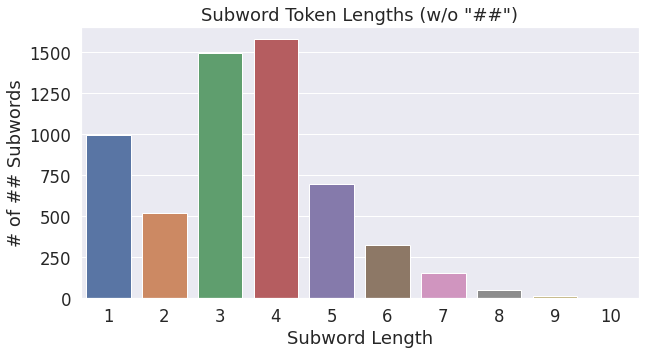

In [14]:
# Длина подслов (исключая два символа '##').
sns.countplot(subword_lengths)
plt.title('Subword Token Lengths (w/o "##")')
plt.xlabel('Subword Length')
plt.ylabel('# of ## Subwords')

In [16]:
# Количество чисел в словаре
count = 0

for token in tokenizer.vocab.keys():

    # Подсчитать количество чисел
    if token.isdigit():
        count += 1
        
        # Число >= 10,000?
        if len(token) > 4:
            print(token)

print('Словарь включает в себя - {:,} число.'.format(count))

Словарь включает в себя - 881 число.


### **Segment ID**

**BERT** обучен и ожидает пары предложений, используя 1 и 0, чтобы различать эти предложения. То есть для каждого токена в «tokenized_text» мы должны указать, к какому предложению он относится: sentence 0 (a series of 0s) or sentence 1 (a series of 1s).

Для одного предложения создадим вектор единиц для каждого токена:


In [ ]:
# Отмечаем каждый из 22 токенов как принадлежащий предложению "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



Если требуется обработать два предложения, тогда необходимо присвоить каждому слову в первом предложении плюс токену «[SEP]» 0, а всем токенам второго предложения - 1.

## **Extracting Embeddings**

### **Running BERT on our text**

In [ ]:
# Ковертируем входы в PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
# Загружаем предобученную модель (BERT(base) - 12 слоёв с encoders)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # При установке значения True модель вернёт все скрытые состояния
                                  )

# Переводим модель из режима обучения в режим оценки, в этом случае dropout regularization отключается
model.eval()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Пропустим текст через BERT модель и извлечем все скрытые состояния сети, полученные из всех 12 слоев
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [ ]:
print(len(hidden_states), hidden_states[0].shape)

13 torch.Size([1, 22, 768])


hidden_states имеет четыре измерения: 
* The layer number (13 layers)
* The batch number (1 sentence)
* The word / token number (22 tokens in our sentence)
* The hidden unit / feature number (768 features)

* 13 слоёв - первый слой input embeddings, остальные - выходы каждого из 12 слоёв BERT 

Всего **219 648** уникальных значения, чтобы представить одно предложение

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


Диапазон значений для конкретного слоя и токена

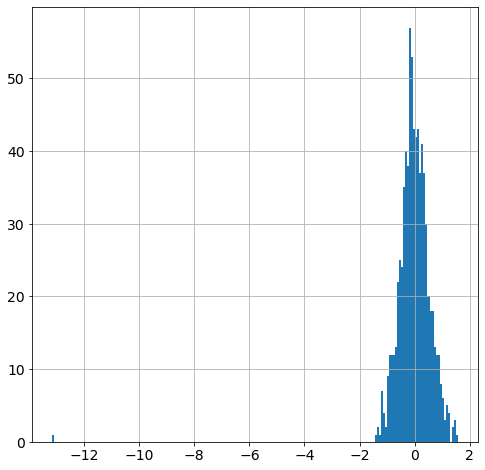

In [ ]:
# Для 5-го токена в предложении берём его векторное представление с 5 слоя сети
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Построим гистограмму для визуализации распределения
plt.figure(figsize=(8,8))
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.hist(vec, bins=200)
plt.show()

диапазон довольно схож для всех слоев и токенов, с большинством значений, лежащих между [-2, 2] и небольшим разбросом значений около -10.

[# layers, # batches, # tokens, # features] -> [# tokens, # layers, # features]

In [ ]:
print('      Type of hidden_states: ', type(hidden_states))
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


Первым измерением в настоящее время является список Python

In [ ]:
# объединим в один тензор
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Удалим измерение 1, соответсвующее батчам 
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Поменяем 0 и 1 измерения местами 
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

### **Creating word and sentence vectors from hidden states**

В итоге для каждого токена предложения у нас есть 13 отдельных векторов длиной 768 каждый.

**Word Vectors**

1. Объединим последние четыре слоя, получив вектор из одного слова для каждого токена. Каждый вектор будет иметь длину 4 x 768 = 3 072.

In [ ]:
token_vecs_cat = []

# token_embeddings - это тензор размера [22 x 13 x 768] 

# Для каждого токена из предложения
for token in token_embeddings:
    
    # token - тензор размера [13 x 768] 
    # Объединим вектора последних 4-х слоёв
    # Длина вектора каждого слоя - 768, тогда cat_vec имеет длину 3 072
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Используем cat_vec для представления token
    token_vecs_cat.append(cat_vec)

print ('Размер cat_vec: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Размер cat_vec: 22 x 3072


2. В качестве альтернативного метода создадим векторы слов, суммируя последние четыре слоя

In [ ]:
token_vecs_sum = []

# token_embeddings - это тензор размера [22 x 13 x 768] 

# Для каждого токена из предложения
for token in token_embeddings:

    # token - тензор размера [13 x 768] 

    # Проссумируем векторы последних четырёх слоёв
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Используем sum_vec для представления token
    token_vecs_sum.append(sum_vec)

print ('Размер sum_vec: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Размер sum_vec: 22 x 768


**Sentence Vectors**

Чтобы получить единый вектор для всего предложения, можно усреднить предпоследний скрытый слой каждого токена, создав один вектор длины 768.

In [ ]:
# hidden_states имеет размер [13 x 1 x 22 x 768]

# token_vecs - тензор размера [22 x 768]
token_vecs = hidden_states[-2][0]

# Усреднение по всем 22 токенам
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print ("Финальный embedding предлоения имеет размер:", sentence_embedding.size())

Финальный embedding предлоения имеет размер: torch.Size([768])


### **Confirming contextually dependent vectors**

Чтобы подтвердить, что значение этих векторов на самом деле зависит от контекста, давайте рассмотрим различные вхождения слова «bank» в нашем примере предложения:

*After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**.*

* Для этого анализа будем использовать векторы слов, которые были созданы путем суммирования последних четырех слоев.

In [ ]:
# определим индекс слова 'bank' в предложении (6, 10, 19)
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


Посчитаем косинусное сходство между векторами, чтобы провести более точное сравнение.

In [ ]:
from scipy.spatial.distance import cosine

# Косинусное расстояние - "bank robber" vs "river bank" - различное значение
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Косинусное расстояние - "bank robber" vs "bank vault" - похожее значение
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Векторное сходство для похожих по значению слов:  %.2f' % same_bank)
print('Векторное сходство для различных по значению слов:  %.2f' % diff_bank)


Векторное сходство для похожих по значению слов:  0.94
Векторное сходство для различных по значению слов:  0.69


### **Pooling Strategy & Layer Choice**

Авторы **BERT** протестировали стратегии построения **word-embeddings**, подав различные векторные комбинации в качестве входных функций в **BiLSTM**, используемый в задаче распознавания именованных объектов, и наблюдая за полученными оценками F1.

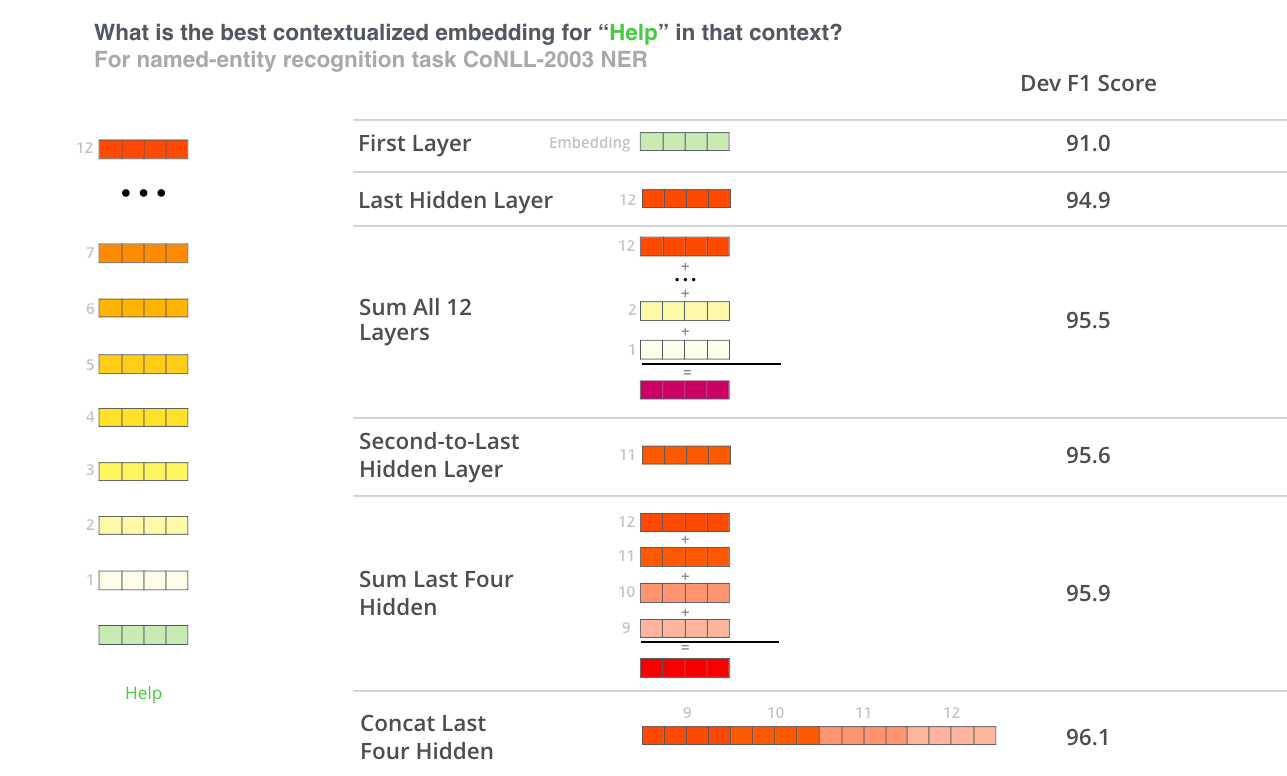

Хотя объединение последних четырех слоев дало наилучшие результаты в этой конкретной задаче,рекомендуется тестировать разные стратегии для конкретного приложения: результаты могут отличаться. Это объясняется тем, что разные слои **BERT** кодируют очень разные виды информации.

Общие рекомендации:
* Embeddings начинаются на первом уровне как не имеющие контекстной информации (т.е. значение первоначального ембединга «bank» не является специфическим для river bank или financial bank).

* По мере того, как embeddings углубляются в сеть, они собирают все больше и больше контекстной информации с каждым уровнем.

* Однако по мере приближения к последнему уровню начинает собираться информация, специфичная для задач предварительного обучения BERT («Masked Language Model» (MLM) и «Next Sentence Prediction» (NSP)). Нам же нужны embeddings, которые хорошо кодируют значение слова. И BERT настроен на это, но он также мотивирован кодировать что-либо еще, что помогло бы ему определить пропущенное слово (MLM) или было ли второе предложение после первого (NSP).

* Поэтому предпоследний слой может являться золотой серединой, подходящей для различных задач.

## **Классификация текста на основе BERT**

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


Используемый набор данных **The Corpus of Linguistic Acceptability (CoLA)** для классификации отдельных предложений. Это набор предложений, помеченных как грамматически правильные или неправильные. Он был впервые опубликован в мае 2018 года и является одним из тестов, включенных в «GLUE Benchmark», в котором конкурируют такие модели, как BERT.

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=b43d8876a38bcb3a6622e9e29590b34a14974fe83a8bd986939bf0a3161a2d91
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget
import os

print('Downloading dataset...')

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
# Unzip the datase
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


### **Parse**

In [ ]:
import pandas as pd

df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Количество предложений в обучении: {:,}\n'.format(df.shape[0]))

# Вывести 10 рандомных предложений
df.sample(10)

Количество предложений в обучении: 8,551



,sentence_source,label,label_notes,sentence
6162,c_13,1,NaN,He is believed to have been at the game.
5438,b_73,1,NaN,He's that reliable a man.
5307,b_82,0,*,1 put the book after the party on the table.
7938,ad03,1,NaN,He left.
6938,m_02,0,*,What she did was be very cold.
1594,r-67,1,NaN,"Although no one else thinks so, Harry thinks t..."
2503,l-93,1,NaN,The guests drank the teapot dry.
2022,rhl07,0,*,Jake shipped the box towards Carson.
6723,m_02,1,NaN,A motorist has reported that the road is block...
6572,g_81,1,NaN,Which city and which conference did Bill go to?


пять предложений, которые отмечены как недопустимые с грамматической точки зрения:

In [ ]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
4889,the person stood on my foot is heavy.,0
4686,He is looked generally on as selfish.,0
5457,John isn't an any more reliable fellow than Bill.,0
912,"I know which book Mag read, and which book Bob...",0
2823,Paula spanked her right hand through the naugh...,0


In [ ]:
sentences = df.sentence.values #извлечение предложений
labels = df.label.values #извлечение меток класса

### **Tokenization & Input Formatting**

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Применение токенезатора BERT к одному предложению

In [ ]:
# Вывод оригинального предложения
print(' Original: ', sentences[0])

# Вывод токенов предложения
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Вывод индексов соответсвующих токенов в словаре 
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [ ]:
max_len = 0

# Для всех предложений
for sent in sentences:

    # Токенезация текста и добавление специальных токенов [CLS] и [SEP]
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Обновление максимальной длины предложения
    max_len = max(max_len, len(input_ids))

print('Максимальная длина предложения: ', max_len)

Максимальная длина предложения:  47


In [ ]:
# Токенизация всех предложений и поиск их индексов в словаре 
input_ids = []
attention_masks = []

# Для всех предложений
for sent in sentences:
    # функция encode_plus включает в себя:
    #   (1) Токенезацию предложения
    #   (2) Добавление специального токена [CLS] в начало предложения
    #   (3) Добавление специального токена [SEP] в конец предложения
    #   (4) Поиск индексов соответсвующих токенов в словаре
    #   (5) Дополнение или укорачивание предложения до max_length
    #   (6) Создание attention masks для токена [PAD] 
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Предложение
                        add_special_tokens = True, # Добавление [CLS] и [SEP]
                        max_length = 64,           # Привести предложение к длине 64
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Создание attention masks
                        return_tensors = 'pt',     # Вернуть pytorch tensors
                   )
    
    # Добавить закодированное предложение в список  
    input_ids.append(encoded_dict['input_ids'])
    
    # Добавить attention masks в список
    attention_masks.append(encoded_dict['attention_mask'])

# lists -> tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Вывести первое предложение для примера
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


Разделим обучающий набор - 90% для обучения и 10% для проверки.

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Создание 90-10 train-validation split.

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# DataLoaders 
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

# Для validation порядок не имеет значения, поэтому просто будем читать данные последовательно
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size
        )

### **Train Classification Model**

Модель **BertForSequenceClassification** - это обычная модель BERT с добавленным одним линейным слоем сверху для классификации, которую мы будем использовать в качестве классификатора предложений. Когда мы вводим входные данные, вся предварительно обученная модель BERT и дополнительный необученный уровень классификации обучаются нашей конкретной задаче.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Загрузка BertForSequenceClassification, предобученной BERT модели с одним линейным (необученным) слоем в конце для классификации
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Использовать модель с 12 слоями и uncased словарём (содержит только строчные буквы)
    num_labels = 2, # Количество выходнов (бинарная классификация в даном случае) 
    output_attentions = False, # Модель не возвращает attentions weights
    output_hidden_states = False, #  Модель не возвращает скрытые состояния
)

model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())

print('The BERT model имеет {:} различных параметра.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# определение гиперпараметров
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
from transformers import get_linear_schedule_with_warmup

# Авторы BERT aрекомендуют от 2 до 4 эпох обучения  2 and 4. 
epochs = 4

# Общее количество этапов обучения - [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs

# Адаптивный шаг обучения
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Функция для вычисления acuracy (predictions vs labels)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

# Вспомогательная функция: приводит время в с к формату hh:mm:ss
def format_time(elapsed):
  
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# training and validation loss, validation accuracy, and timings.
training_stats = []

# Измерение общего времени обучения
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Вывод результата каждые every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        result = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        # Обрезать норму градиентов до 1.0.
         # Это помогает предотвратить проблему "взрывающихся градиентов".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # Обновление шага обучения
        scheduler.step()

    # Вычисление среднего loss на всех the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Измерения длительности эпохи
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            result = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Все статистики за эпоху
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:26.
  Batch    80  of    241.    Elapsed: 0:00:53.
  Batch   120  of    241.    Elapsed: 0:01:19.
  Batch   160  of    241.    Elapsed: 0:01:46.
  Batch   200  of    241.    Elapsed: 0:02:12.
  Batch   240  of    241.    Elapsed: 0:02:39.

  Average training loss: 0.49
  Training epcoh took: 0:02:39

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.46
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:26.
  Batch    80  of    241.    Elapsed: 0:00:53.
  Batch   120  of    241.    Elapsed: 0:01:19.
  Batch   160  of    241.    Elapsed: 0:01:46.
  Batch   200  of    241.    Elapsed: 0:02:12.
  Batch   240  of    241.    Elapsed: 0:02:39.

  Average training loss: 0.31
  Training epcoh took: 0:02:39

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.51
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
 

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.46,0.80,0:02:39,0:00:06
2,0.31,0.51,0.81,0:02:39,0:00:06
3,0.20,0.53,0.83,0:02:39,0:00:06
4,0.14,0.62,0.83,0:02:39,0:00:06


Потери в обучении уменьшаются с каждой эпохой, потеря валидации увеличивается. Это говорит о том, что модель обучается слишком долго и не соответствует обучающим данным.


Если мы предсказываем правильный ответ, но с меньшей уверенностью, то validation  loss уловит это, а accuracy - нет.



([<matplotlib.axis.XTick at 0x7fc7f1201150>,
 <a list of 4 Text major ticklabel objects>)

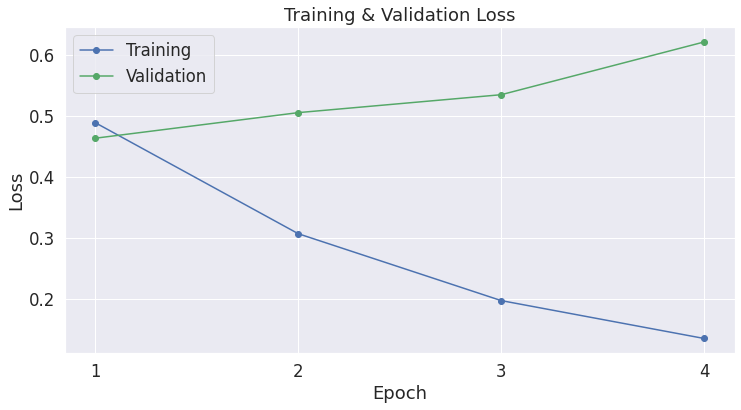

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

### **Performance On Test Set**

Метрика качества -  Matthew’s correlation coefficient (+1 - лучший результат, а -1 - худший результат. )

In [ ]:
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print('Количество предложений в тестовом наборе: {:,}\n'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',   
                   )
       
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Количество предложений в тестовом наборе: 516



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Предсказания для тестового набора данных
model.eval()
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Matthew's correlation coefficient для каждого batch
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten() 
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


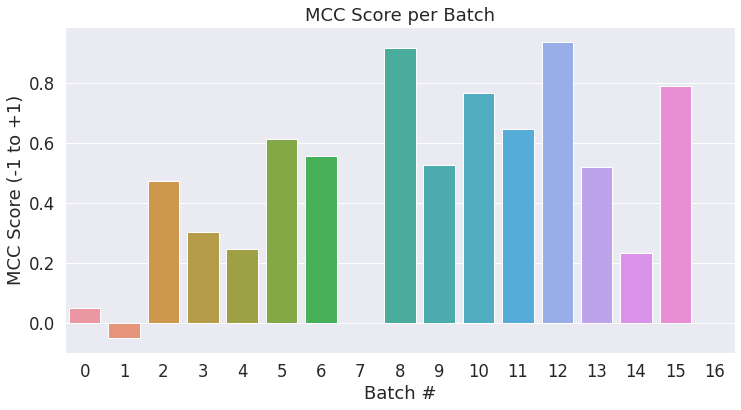

In [ ]:
# MCC score для каждого batch (в batch по 32 предложения, за исключением последнего, где 4 предложения)
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Объединяем результат всех batches предсказанных значений 
flat_predictions = np.concatenate(predictions, axis=0)

# Для каждого объекта выбрать метку (0 или 1) с более высокой оценкой 
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Объединяем результат всех batches реальных значений
flat_true_labels = np.concatenate(true_labels, axis=0)

# MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.519
